#  <span style="color:pink">CAMPUS PRIDE INDEX</span>
<span style="color:olive">**2024 Tidytuesday  Week 24** </span>

## Setup

### Libraries

In [250]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from shapely.geometry import Polygon

from PIL import Image
from matplotlib.patches import Patch, Circle
from matplotlib import rcParams
from matplotlib import font_manager


### Font and colors

In [3]:
font_dirs =  ['/Library/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

#rcParams['font.family'] = 'Roboto'

### Load Data

In [6]:
# os.getcwd()
os.listdir('map_data')

['cb_2018_us_state_500k.dbf',
 'cb_2018_us_state_500k.shp.iso.xml',
 'cb_2018_us_state_500k.shx',
 'cb_2018_us_state_500k.shp',
 'cb_2018_us_state_500k.cpg',
 'cb_2018_us_state_500k.shp.ea.iso.xml',
 'cb_2018_us_state_500k.prj']

In [ ]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

#### Pride index data

In [11]:
tt_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/'
index_data = 'data/2024/2024-06-11/pride_index.csv'
tags_data = 'data/2024/2024-06-11/pride_index_tags.csv'

idx_df = pd.read_csv(tt_url + index_data)
tags_df = pd.read_csv(tt_url + tags_data)

#### US states map data

In [21]:
gdf = gpd.read_file(os.getcwd()+'/map_data')

## EDA

### Overview

In [22]:
gdf.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [12]:
idx_df.head(3)

,campus_name,campus_location,rating,students,community_type
0,"University of Maryland, College Park","College Park, MD",5.0,37952,large urban city
1,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city
2,SUNY Westchester Community College,"Valhalla, NY",4.0,13000,very small town


In [15]:
tags_df.columns

Index(['campus_name', 'campus_location', 'public', 'private', 'doctoral',
       'masters', 'baccalaureate', 'community', 'residential',
       'nonresidential', 'liberal_arts', 'technical', 'religious', 'military',
       'hbcu', 'hispanic_serving', 'aapi_serving', 'other_minority_serving'],
      dtype='object')

### Merging data

In [266]:
df = idx_df.merge(tags_df, on = ['campus_name', 'campus_location'])
df.head()

,campus_name,campus_location,rating,students,community_type,public,private,doctoral,masters,baccalaureate,...,residential,nonresidential,liberal_arts,technical,religious,military,hbcu,hispanic_serving,aapi_serving,other_minority_serving
0,"University of Maryland, College Park","College Park, MD",5.0,37952,large urban city,True,NaN,True,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
1,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city,True,NaN,True,True,True,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SUNY Westchester Community College,"Valhalla, NY",4.0,13000,very small town,True,NaN,NaN,NaN,NaN,...,NaN,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
3,University at Buffalo,"Buffalo, NY",3.5,29850,medium city,True,NaN,True,True,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Slippery Rock University,"Slippery Rock, PA",4.0,8500,rural community,True,NaN,True,True,True,...,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Wrangling

**Separate city and state**

In [267]:
df.loc[:, 'campus_location'].head(3)

0    College Park, MD
1        Dearborn, MI
2        Valhalla, NY
Name: campus_location, dtype: object

In [268]:
df['location'] = df['campus_location'].str.split(', ', expand=True)[0]
df['state_abbr'] = df['campus_location'].str.split(', ', expand=True)[1]

In [269]:
# df['location'] = df.apply(lambda row: row['campus_location'].split(' '), axis=1)[0]
df.loc[:, ['campus_location', 'location', 'state_abbr']].head()

,campus_location,location,state_abbr
0,"College Park, MD",College Park,MD
1,"Dearborn, MI",Dearborn,MI
2,"Valhalla, NY",Valhalla,NY
3,"Buffalo, NY",Buffalo,NY
4,"Slippery Rock, PA",Slippery Rock,PA


#### Campus Pride Index: Average Rating by state

In [270]:
by_state_cpi = df.groupby('state_abbr')['rating'].mean().round(0).reset_index()
by_state_cpi.head(3)

,state_abbr,rating
0,AL,4.0
1,AR,2.0
2,AZ,4.0


### Merging Rating and Map data

In [271]:
map_df = gdf.merge(by_state_cpi,left_on='STUSPS',right_on='state_abbr', how = 'outer')
map_df.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state_abbr,rating
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",NaN,NaN
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",NC,4.0


In [111]:
len(by_state_cpi.state_abbr)     # Only 41 states and DC have data.
by_state_cpi.state_abbr

0     AL
1     AR
2     AZ
3     CA
4     CO
5     CT
6     DC
7     FL
8     GA
9     ID
10    IL
11    IN
12    KS
13    KY
14    MA
15    MD
16    ME
17    MI
18    MN
19    MO
20    MT
21    NC
22    ND
23    NE
24    NH
25    NJ
26    NM
27    NY
28    OH
29    OK
30    OR
31    PA
32    RI
33    SD
34    TN
35    TX
36    UT
37    VA
38    VT
39    WA
40    WI
41    WV
Name: state_abbr, dtype: object

In [112]:
gdf.STUSPS

0     MS
1     NC
2     OK
3     VA
4     WV
5     LA
6     MI
7     MA
8     ID
9     FL
10    NE
11    WA
12    NM
13    PR
14    SD
15    TX
16    CA
17    AL
18    GA
19    PA
20    MO
21    CO
22    UT
23    TN
24    WY
25    NY
26    KS
27    AK
28    NV
29    IL
30    VT
31    MT
32    IA
33    SC
34    NH
35    AZ
36    DC
37    AS
38    VI
39    NJ
40    MD
41    ME
42    HI
43    DE
44    GU
45    MP
46    RI
47    KY
48    OH
49    WI
50    OR
51    ND
52    AR
53    IN
54    MN
55    CT
Name: STUSPS, dtype: object

In [115]:
map_df.STUSPS

0     MS
1     NC
2     OK
3     VA
4     WV
5     LA
6     MI
7     MA
8     ID
9     FL
10    NE
11    WA
12    NM
13    PR
14    SD
15    TX
16    CA
17    AL
18    GA
19    PA
20    MO
21    CO
22    UT
23    TN
24    WY
25    NY
26    KS
27    AK
28    NV
29    IL
30    VT
31    MT
32    IA
33    SC
34    NH
35    AZ
36    DC
37    AS
38    VI
39    NJ
40    MD
41    ME
42    HI
43    DE
44    GU
45    MP
46    RI
47    KY
48    OH
49    WI
50    OR
51    ND
52    AR
53    IN
54    MN
55    CT
Name: STUSPS, dtype: object

### Extrapolation

In [273]:
raiting_average = map_df['rating'].mean().round(0)

In [274]:
map_df['rating_2'] = map_df['rating'].fillna(raiting_average)

In [275]:
map_df.loc[:, ['STUSPS', 'state_abbr', 'rating','rating_2']].head(3)

,STUSPS,state_abbr,rating,rating_2
0,MS,NaN,NaN,4.0
1,NC,NC,4.0,4.0
2,OK,OK,4.0,4.0


## Viz-1
[source](https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6)

### Basic map

<Axes: >

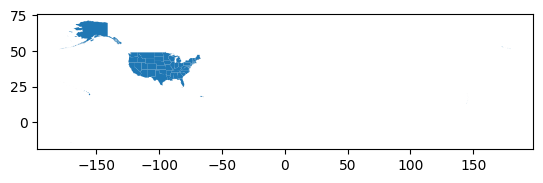

In [263]:
gdf.plot()

### Projections

In [276]:
visframe = map_df.to_crs({'init':'epsg:2163'})

/Users/birusod/Documents/DataScienceDocs/GitProjects/Projects2024/.pvenv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [119]:
type(visframe)

geopandas.geodataframe.GeoDataFrame

In [277]:
visframe.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state_abbr,rating,rating_2
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((1109990.968 -1565553.473, 1111...",NaN,NaN,4.0
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((2154835.730 -692236.318, 21554...",NC,4.0,4.0


### Continental US

Remove: Puerto Rico, Guam, Mariana Islands, Virgin Islands

In [291]:
us_frame = visframe[~visframe.loc[:, 'STUSPS'].isin(['PR', 'AS', 'VI', 'MP', 'GU'])].copy()

<Axes: >

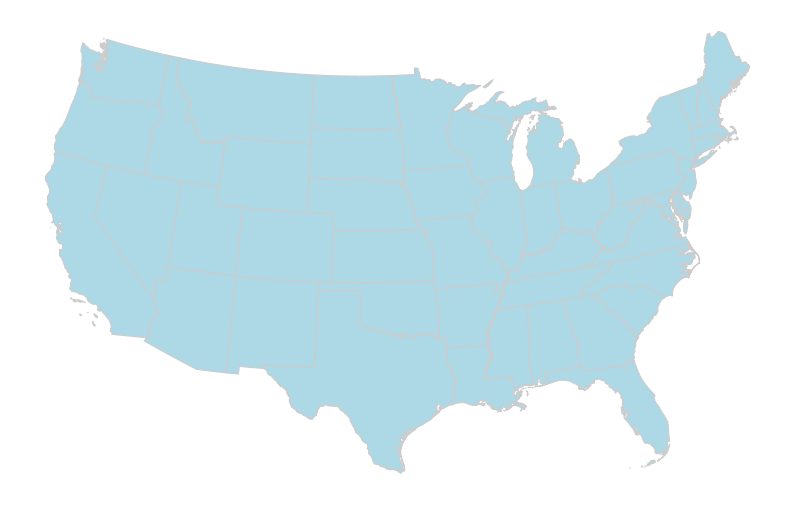

In [292]:
# create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(10, 9))
# remove the axis box from the main map
ax.axis('off')

# create map of all states except AK and HI in the main map axis
us_frame[~us_frame.STUSPS.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


### Alaska and Hawaii

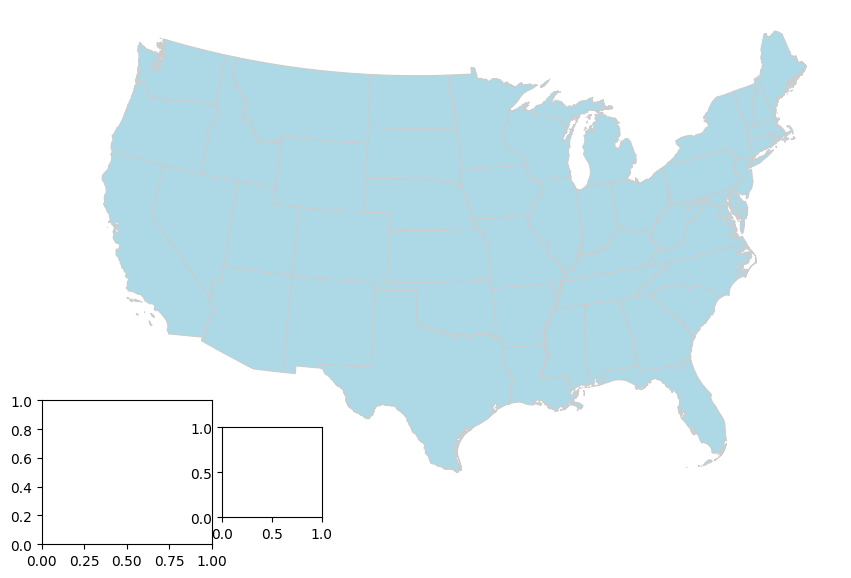

In [293]:
fig, ax = plt.subplots(1, figsize=(10, 9))
ax.axis('off')

us_frame[~us_frame.STUSPS.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8').plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])  

### Colors column by state

In [294]:
# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(df,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    df['value_determined_color'] = df.loc[:, variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return df

### Mapping Rating by State

In [295]:
us_frame.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state_abbr,rating,rating_2
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((1109990.968 -1565553.473, 1111...",NaN,NaN,4.0
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((2154835.730 -692236.318, 21554...",NC,4.0,4.0


In [244]:
us_frame.rating.max()

5.0

### set the value column that will be visualised and colors scale

In [296]:
variable = 'rating_2'
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "RdYlGn"

### Create column for value_determined_color in data

In [341]:

# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = us_frame.rating_2.min(), us_frame.rating_2.max() #math.ceil(gdf.pct_food_insecure.max())
map_dfc2 = makeColorColumn(us_frame,variable,vmin,vmax)
map_dfc2.value_determined_color

0     #e1640e
1     #e1640e
2     #e1640e
3     #e1640e
4     #e1640e
5     #e1640e
6     #e1640e
7     #e1640e
8     #ffffe5
9     #e1640e
10    #662506
11    #e1640e
12    #e1640e
14    #ffffe5
15    #e1640e
16    #e1640e
17    #e1640e
18    #e1640e
19    #e1640e
20    #e1640e
21    #e1640e
22    #e1640e
23    #e1640e
24    #e1640e
25    #e1640e
26    #e1640e
27    #e1640e
28    #e1640e
29    #e1640e
30    #662506
31    #e1640e
32    #e1640e
33    #e1640e
34    #e1640e
35    #e1640e
36    #e1640e
39    #e1640e
40    #e1640e
41    #e1640e
42    #e1640e
43    #e1640e
46    #fece65
47    #e1640e
48    #e1640e
49    #e1640e
50    #e1640e
51    #e1640e
52    #ffffe5
53    #662506
54    #662506
55    #e1640e
Name: value_determined_color, dtype: object

### Reset project => new frame: vfc

In [342]:
map_dfc2['state'] = map_dfc2.loc[:, 'STUSPS']
vfc = map_dfc2.to_crs({'init':'epsg:2163'})
vfc[['NAME', 'state']].head(2)


/Users/birusod/Documents/DataScienceDocs/GitProjects/Projects2024/.pvenv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,NAME,state
0,Mississippi,MS
1,North Carolina,NC


In [343]:
vfc[(vfc.state == 'AK') | (vfc.state == 'HI')]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state_abbr,rating,rating_2,value_determined_color,state
27,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((-4288629.978 3426273.416, -428...",NaN,NaN,4.0,#e1640e,AK
42,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-5544643.751 -943550.426, -554...",NaN,NaN,4.0,#e1640e,HI


### Create Fig and Axes

/var/folders/9w/v257qsg5293f6s1lh74pbb6m0000gn/T/ipykernel_24660/699516415.py:53: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color= map_dfc2[map_dfc2.state=='HI'].value_determined_color, linewidth=0.8,ax=hiax, edgecolor='0.8')


<Axes: >

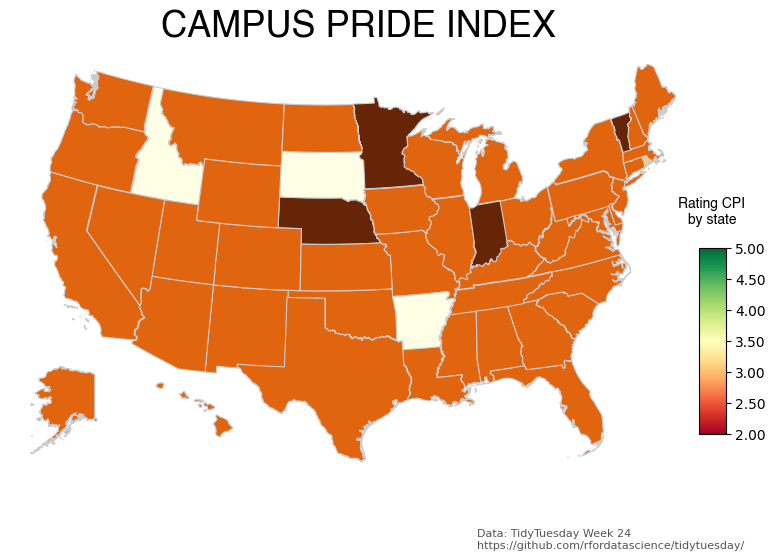

In [344]:
fig, ax = plt.subplots(1, figsize=(9, 6))
ax.axis('off')

hfont = {'fontname':'Helvetica'}   # set the font
ax.set_title('CAMPUS PRIDE INDEX', **hfont, fontdict={'fontsize': '26', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  #colorbar: [l,b,w,h] l:left, b:bottom, w:width, h:height; in normalized unit (0-1)

cbax.set_title('Rating CPI\nby state\n', **hfont, fontdict={'fontsize': '10', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))

# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x, '.2f'))
fig.colorbar(sm, cax=cbax, format=comma_fmt) # 
tick_font_size = 10
cbax.tick_params(labelsize=tick_font_size)

# annotate the data source, date of access, and hyperlink
ax.annotate(
    "Data: TidyTuesday Week 24\nhttps://github.com/rfordatascience/tidytuesday/", 
    xy=(0.53, .02), xycoords='figure fraction', fontsize=8, color='#555555')


# create map: color state by state using loop
for row in vfc.itertuples():
    if row.state not in ['AK','HI']:
        vf = vfc[vfc.state==row.state]
        c = map_dfc2[map_dfc2.state==row.state][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# Alaska and Hawaii
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   
akax.axis('off')

polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = map_df[map_df.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color=map_dfc2[map_dfc2.state=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = map_df[map_df.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color= map_dfc2[map_dfc2.state=='HI'].value_determined_color, linewidth=0.8,ax=hiax, edgecolor='0.8')




## Viz-2
[source](https://dev.to/oscarleo/how-to-create-data-maps-of-the-united-states-with-matplotlib-p9i)

### color and style

In [348]:
edge_color = "#30011E"
background_color = "#fafafa"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})

### Data

In [370]:
raw_df = gpd.read_file("./map_data/")
raw_df[raw_df.STUSPS.isin(['PR', 'GU', 'VI', 'AS', 'MP', 'AK', 'HI'])].STATEFP

13    72
27    02
37    60
38    78
42    15
44    66
45    69
Name: STATEFP, dtype: object

In [374]:
states = raw_df[~raw_df.STATEFP.isin(["72", "69", "60", "66", "78"])] # "02", "15", 
states_proj = states.to_crs("ESRI:102003")
states.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


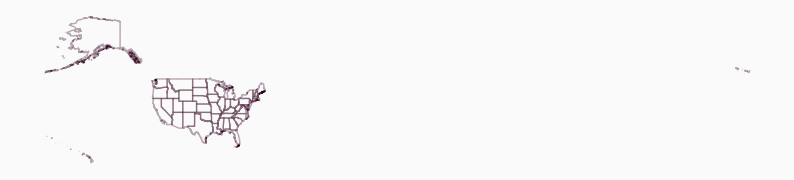

In [375]:
ax = states.plot(edgecolor=edge_color + "55", color="None", figsize=(10, 9))
plt.axis("off")
plt.show()

**Adjusted map projection to one centered on the United States**

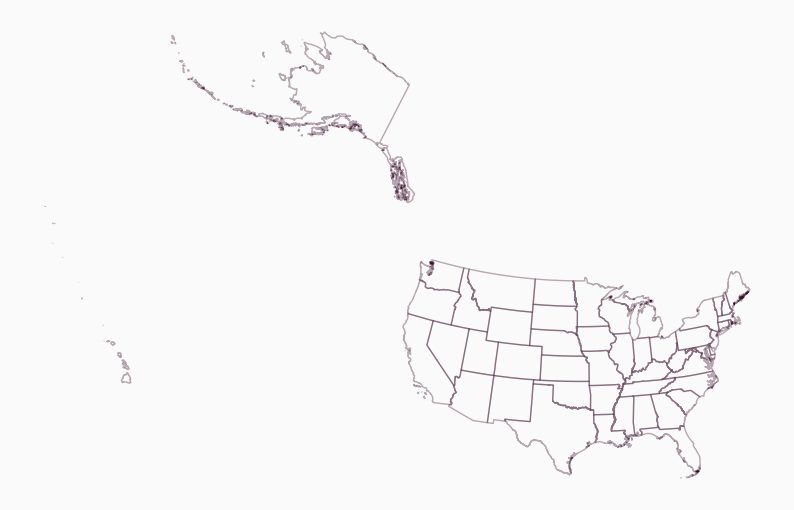

In [377]:
ax = states_proj.plot(edgecolor=edge_color + "55", color="None", figsize=(10, 9))
plt.axis("off")
plt.show()

### Drawing Alaska and Hawaii underneath the mainland

**Function to translate, scale, and rotate geometries with built-in functions using `geopandas`**

In [378]:
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

**Function to adjust AK and HI geometries:**

The  function takes our current data frames, separates Hawaii and Alaska, calls translate_geometries() to adjust their geometries, and put them back into new data frames.

In [379]:
def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [403]:
states_adj = adjust_maps(states_proj)

### Final map data

In [406]:
states_adj_new = states_adj.copy()
states_adj_new.loc[:, 'state'] = states_adj_new.STUSPS
states_adj_final = states_adj_new.set_index('state')

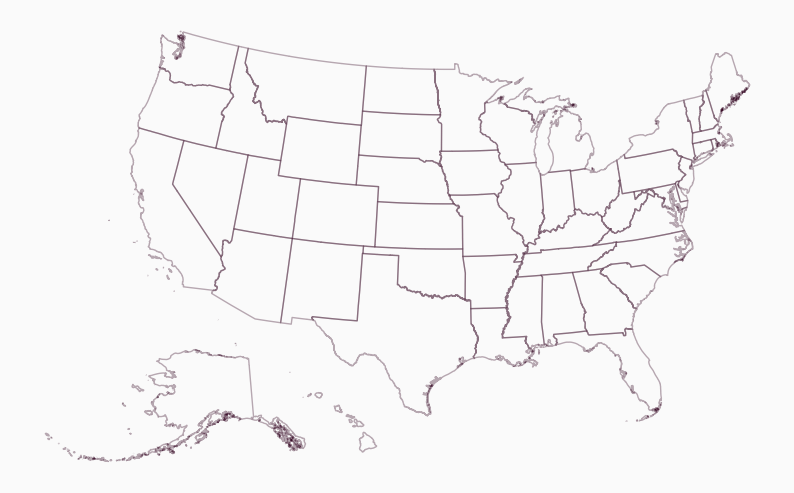

In [408]:
ax = states_adj_final.plot(edgecolor=edge_color + "55", color="None", figsize=(10, 9))
plt.axis("off")
plt.show()

### Adding CPI rating data

In [400]:
cpi_df = by_state_cpi.rename(columns={'state_abbr':'state'})
cpi_df.head(2)

,state,rating
0,AL,4.0
1,AR,2.0


### Colors

In [384]:
selected_color = "#FA26A0"
data_breaks = [
    (5, "#00ffff", "CPI-5"),
    (4, "#00b5ff", "CPI-4"),
    (3, "#6784ff", "CPI-3"),
    (2, "#aeb3fe", "CPI-2"),
    (1, "#e6e5fc", "CPI-1"),
]

Defines the color for each row using a state_df and the data_breaks we just defined

In [385]:
def create_color(state_df, data_breaks):
    colors = []

    for i, row in state_df.iterrows():
        for p, c, _ in data_breaks:
            if row.value >= p:
                colors.append(c)
                break

    return colors

**Calculate the correct values and add `create_color()`**

Add rating column to mapping data

In [409]:
states_adj_final.loc[:, 'value'] = (cpi_df.set_index('state').rating)

Fill na with zeros:

In [423]:
states_adj_final.loc[:, 'value'] =  states_adj_final.value.fillna(0)
states_adj_final.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,value
state,,,,,,,,,,,
MS,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((719952.837 -785108.098, 721081...",0.0
NC,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((1799007.580 17387.012, 1799662...",4.0


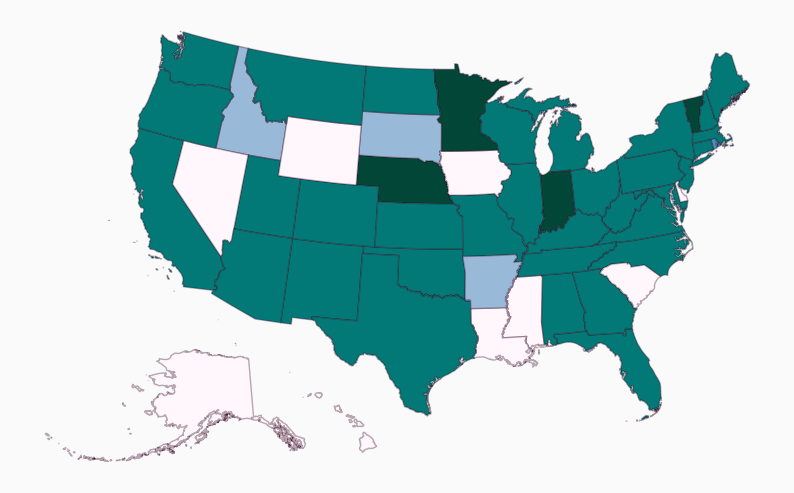

In [421]:
states_adj_final.plot(
    edgecolor=edge_color + "55", figsize=(10, 9),
    column='value', cmap='PuBuGn')

plt.axis("off")
plt.show()
    

### Adding information

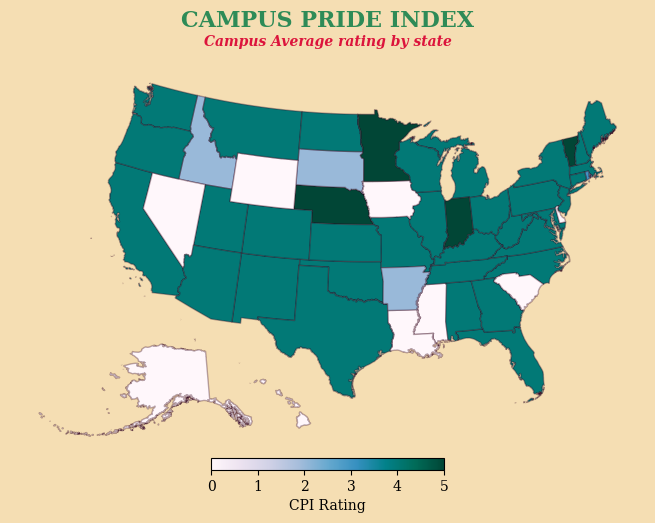

In [481]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor= "wheat")

states_adj_final.plot(
    ax=ax,
    edgecolor=edge_color + "55", #figsize=(10, 6),
    column='value', cmap='PuBuGn', 
    legend=True, legend_kwds={
        "shrink":.3, "location":"bottom",
        'label': 'CPI Rating', "pad":0.01
        } #categorical=True, 
    )

plt.annotate(
        text="CAMPUS PRIDE INDEX",
        xy=(0.5, 1.1), 
        xycoords="axes fraction", 
        fontsize=16, color = 'seagreen', ha="center", fontweight="bold"
    )
plt.annotate(
        text="Campus Average rating by state", 
        xy=(0.5, 1.05), 
        xycoords="axes fraction", 
        fontsize=10, color = 'crimson', ha="center", fontweight="bold", fontstyle='italic'
    )

cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=10, labelcolor='black')


plt.axis("off")
plt.show()

## Viz-3: Plotly

In [486]:
import plotly.express as px
import plotly.graph_objects as go

In [485]:
fig = go.Figure(go.Scattergeo())
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)
fig.update_layout(height=400, width=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [489]:
map_dfc2.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'state_abbr', 'rating', 'rating_2',
       'value_determined_color', 'state'],
      dtype='object')

In [507]:
fig = px.choropleth(locations=map_dfc2["state"], 
                    locationmode="USA-states", 
                    color=map_dfc2["rating_2"], 
                    scope="usa", 
                    color_continuous_scale="Viridis",
                    title="<b>CAMPUS PRIDE INDEX</b>")
fig.update_layout(
    height=400, width=600, 
    margin={"r":0,"t":50,"l":0,"b":0},
    title_font_family="Roboto",
    title_font_size=20,
    title_font_color="seagreen")
fig.show()